In [152]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from collections import deque

In [153]:
# Enums
class Color(Enum):
    BLACK = 0
    RED = 1
    BLUE = 2
    YELLOW = 3
    GREEN = 4

class Label(Enum):
    DANGEROUS = 0
    SAFE = 1

COLOR_TO_RGB = {
    0 : (0, 0, 0),
    1 : (255, 0, 0),
    2 : (0, 0, 255),
    3 : (255, 255, 0),
    4 : (0, 255, 0)
}

In [154]:
# Image Generation
class Image: # USE THIS CLASS TO DISPLAY / CREATE IMAGE
    def __init__(self, data, label, third_wire):
        self.data = data
        self.label = label
        self.third_wire = third_wire

    def display(self):
        n = self.data.shape[0]
        image_data = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                curr_val = self.data[i][j]
                image_data[i][j] = COLOR_TO_RGB[curr_val]

        plt.imshow(image_data)
        plt.axis("off")
        plt.show()

class DataSet:
    def __init__(self):
        self.image_data = []
        self.labels = []
        self.third_wires = []

    def add_image(self, image, label, third_wire):
        """Add an image to the dataset using raw data"""
        self.image_data.append(image)
        self.labels.append(label.value)
        self.third_wires.append(third_wire) 

class ImageGenerator:
    """Generates N (M x M) images and writes to data"""
    def __init__(self, num_images, dimensions = 20, write_path = None, dataset = None, seed = None):
        self.dimensions = dimensions
        self.seed = seed
        random.seed(seed)
        for _ in range(num_images):
            data, label, third_wire = self.generate(write_path is not None)
            if dataset is not None:
                dataset.add_image(data, label, third_wire)

            # TODO: Write to data (may not be necessary, gen is really fast)
            if write_path is not None:
                pass

    def generate(self, write_ = False):
        """Generate a single image and label it appropriately"""
        n = self.dimensions
        image_data = np.full((n, n), Color.BLACK.value)
        colors = [Color.RED, Color.BLUE, Color.YELLOW, Color.GREEN]

        # Keep track of rows/cols that can be used
        valid_rows = list(range(n))
        valid_cols = list(range(n))

        # 1  = Color Row
        # -1 = Color Col
        pointer = random.choice([1, -1])
        label = Label.SAFE
        yellow_placed = False
        third_wire = None

        for i in range(4):
            # Select a unused color
            curr_color = random.choice(colors)
            colors.remove(curr_color)

            # Determine which should be cut (if dangerous)
            if i == 2:
                third_wire = curr_color
            
            # Handle marking an image as DANGEROUS if red is placed before yellow
            yellow_placed = yellow_placed or curr_color == Color.YELLOW
            if curr_color == Color.RED and not yellow_placed:
                label = Label.DANGEROUS

            if pointer == 1:
                rand_idx = random.choice(valid_rows)
                valid_rows.remove(rand_idx)
                self.color_row(rand_idx, curr_color, image_data)
            else:
                rand_idx = random.choice(valid_cols)
                valid_cols.remove(rand_idx)
                self.color_column(rand_idx, curr_color, image_data)
                
            pointer *= -1
        
        return image_data, label, third_wire
            

    def color_column(self, col, color, arr):
        """Color the given column of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[i][col] = color.value

    def color_row(self, row, color, arr):
        """Color the given row of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[row][i] = color.value

In [155]:
data = DataSet()
img_gen = ImageGenerator(50, dataset = data, seed = 718067190)

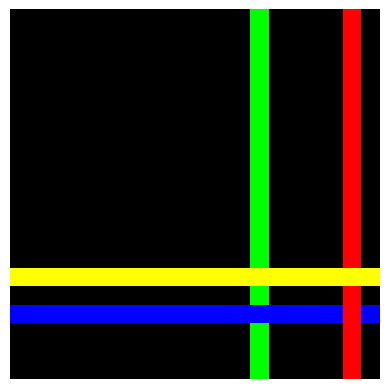

In [156]:
def load_image(dataset_obj, index):
    """Load a specific index of the dataset"""
    image_data = dataset_obj.image_data[index]
    label = dataset_obj.labels[index]
    third_wire = dataset_obj.third_wires[index]
    img = Image(image_data, label, third_wire)
    return img

load_image(data, 20).display()

In [157]:
# Math Stuff
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [191]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, examples, labels, alpha, epsilon):
        self.n = len(examples)                                # of training examples
        self.d = len(examples[0])                             # of features
        self.examples = np.c_[np.ones(self.n), examples]      # Add column of 1s for W_0
        self.labels = labels                                  # Classification Labels
        self.weights = np.zeros(self.d + 1)                # Current parameters / weights
        self.lr = alpha                                    # Learning rate   
        self.epsilon = epsilon

    def predict(self, inds=None):
        """Compute h_w(x_i) for the provided weight values"""
        if inds is None:
            inds = np.arange(len(self.examples))
        
        dot_product = np.dot(self.examples[inds], self.weights)
        return sigmoid(dot_product)


    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        return np.mean(-y * np.log(p) - (1 - y) * np.log(1 - p))

    def gd(self):
        """Run Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        # random.shuffle(self.examples)
        # for i in range(len(self.examples)):
        #errors = self.loss(self.labels, self.predict())
        residuals = self.predict() - self.labels
        gradient = np.dot(self.examples.T, residuals) / self.n
        self.weights -= self.lr * gradient
        
    def sgd(self):
        """Run Stochastic Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.examples))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.labels[ind]
            gradient = residual * self.examples[ind]
            self.weights -= self.lr * gradient

    def train_sgd(self, epochs):
        prev = deque([float('inf')])
        for epoch in range(epochs):
            self.sgd()
            current_loss = self.loss(self.labels, self.predict())
            print(f"{epoch} - Loss: {current_loss}")
            
            rolling_mean = sum(prev)/len(prev)
            if rolling_mean - current_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {current_loss}")
                break
            prev.append(float(current_loss))
            if len(prev) > 5:
                prev.popleft()
            
    def train_gd(self, epochs):
        prev = float('inf')
        for epoch in range(epochs):
            self.gd()
            current_loss = self.loss(self.labels, self.predict())
            print(f"{epoch} - Loss: {current_loss}")
            if prev - current_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {current_loss}")
                break
            prev = current_loss

    # Regular GD with the same early stopping condition as SGD
    
    # def train_gd(self, epochs):
    #     prev = deque([float('inf')])
    #     for epoch in range(epochs):
    #         self.gd()
    #         current_loss = self.loss(self.labels, self.predict())
    #         print(f"{epoch} - Loss: {current_loss}")
    #         
    #         rolling_mean = sum(prev)/len(prev)
    #         if rolling_mean - current_loss < self.epsilon:
    #             print(f"Stopping early at epoch {epoch} - Loss: {current_loss}")
    #             break
    #         prev.append(float(current_loss))
    #         if len(prev) > 5:
    #             prev.popleft()

    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < 5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

In [192]:
# Preprocess data (this should be done somewhere else, but here for now)
image_data = np.array(data.image_data)
label_data = np.array(data.labels)
flattened_data = image_data.reshape(image_data.shape[0], -1)
flattened_data

array([[0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [193]:
lr = .01
epsilon = .001#.001

logistic = LogisticRegression(flattened_data, label_data, lr, epsilon)
predictions = logistic.predict()
loss = logistic.loss(logistic.labels, predictions)
predictions

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [194]:
gd = logistic.train_gd(20000)


0 - Loss: 0.6678100999116309
1 - Loss: 0.6463966646615411
2 - Loss: 0.6279321157436055
3 - Loss: 0.6117524044218718
4 - Loss: 0.5973923160863936
5 - Loss: 0.5845147398250198
6 - Loss: 0.572867126134453
7 - Loss: 0.5622546770879252
8 - Loss: 0.552523524073432
9 - Loss: 0.5435498366926135
10 - Loss: 0.5352325002008094
11 - Loss: 0.52748799762632
12 - Loss: 0.5202467031765879
13 - Loss: 0.51345011568962
14 - Loss: 0.5070487434103192
15 - Loss: 0.5010004563767247
16 - Loss: 0.49526918467480274
17 - Loss: 0.489823878653017
18 - Loss: 0.4846376712029767
19 - Loss: 0.47968719808965204
20 - Loss: 0.47495204322635204
21 - Loss: 0.47041428354930853
22 - Loss: 0.4660581138231741
23 - Loss: 0.46186953595520736
24 - Loss: 0.45783610062782637
25 - Loss: 0.45394669155132583
26 - Loss: 0.4501913445795446
27 - Loss: 0.4465610954548016
28 - Loss: 0.44304785115174705
29 - Loss: 0.4396442807451107
30 - Loss: 0.4363437224881782
31 - Loss: 0.43314010439878087
32 - Loss: 0.43002787613972565
33 - Loss: 0.4270

In [182]:
predictions = logistic.predict()

# for i in range(len(predictions)):
#     if predictions[i] < 0.5:
#         predictions[i] = int(0)
#     else:
#         predictions[i] = int(1)
predictions = logistic.get_pred_labels(predictions)

predictions

array([0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [111]:
logistic.labels

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1])